# Gridsearch, cross-validation and hyperparameters

## Cross-validation

In building a regression model, splitting input data between train and test set is key to be able to correctly evaluate a model performance. However, there is a high variance in what falls into the training set and what falls into the test set with different random splits. This is not good, as it leads to inconsistency in the results and means we can't be confident in the evaluation scores we see.

In [ ]:
# Load Boston housing data set
boston = pd.read_csv("boston.csv")

# Define the X (input) and y (target) features
X = boston.drop("MEDV", axis=1)
y = boston["MEDV"]

# Rescale the input features
scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

#splitting your dataset into training and test sets, based on random sampling and returns 
# an evaluation of the model based on R-squared score
# Train test split
test_size = 0.33
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# Create model
model = LinearRegression()

# Fit model
model.fit(X_train, y_train)

# Evaluate model
predictions = model.predict(X_test)
r2_score(y_test, predictions)

We use the term resampling to refer to techniques that draw samples from a data set. Train / test split is a very simple resampling method, but there are better techniques. 

Cross-validation methods are used to provide a more robust evaluation of models. They work by splitting the dataset into multiple training and test sets and running the evaluation multiple times (as much as the number of folds). We can then compute an overall evaluation score by taking the mean of the k scores. In this way, we get a more robust evaluation of our models. They are less susceptible to being poorly evaluated due to the luck of the draw in the random sampling, because we've tested with k different cuts of the data. Generally, a k somewhere between 5 and 10 will give you good results.

### use of k-fold cross-validation
We can incorporate k-fold cross-validation very easily into our investigations using Sklearn.

In [ ]:
# Create 5 folds
seed = 7
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# Create a model 
model = LinearRegression()

# Train and evaluate multiple models using kfolds
results = cross_val_score(model, X, y, cv=kfold, scoring='r2')
print(results)
print("Mean:", results.mean())
print("Std:", results.std())

#Note that we don't need to explicitly perform the train/test splits. 
#The KFold object passed to the cross_val_score() function does this for us.

The results list is the list of 5 R-squared scores, one for each of the k model evaluations. I've also shown the mean and standard deviation of these 5 scores, as a summary of the overall performance of linear regression across all 5 models.


The above example uses R-squared, but you can use different evaluation metrics. You can get a list of possible evaluation metrics (for both classification and regression) by running this code

In [ ]:
from sklearn.metrics import SCORERS
sorted(SCORERS.keys())

We can also get the predictions from the cross-validation analysis. Note that these are not actually model predictions as we are evaluating multiple models (one for each fold). Nevertheless, they can give a useful way of checking the potential real model predictions

In [ ]:
cross_val_predict(model, X, y, cv=kfold)
# Note that the above model is not fitted when cross_val_score() returns. 
#The following inspection of the model returns an error:
model.coef_

### Finalise model

Once we have completed the evaluation of our models, the train and test sets in a train/test split or folds in k-fold cross-validation have done their job. We can discard them and the models we created with them. 

To build our final model, we can pick the best performing algorithm, the best algorithm parameters, and the best feature set and fit a model using the entire data set:

In [ ]:
#If we want to proceed to build our final model we can fit it using ALL the data:
model.fit(X, y)
#Get the cross-validation predictions:
cross_val_predict(model, X, y, cv=kfold)
# Get a list of alternative evaluation metrics that can be used in the call to cross_val_score():
from sklearn.metrics import SCORERS
sorted(SCORERS.keys())

## Tuning a ML algorithm

### Hyperparameters
In machine learning, we use the term parameters to refer to something that can be learned by the algorithm during training and hyperparameters to refer to something that is passed to the algorithm.
For example:

   - The number of neighbors to inspect in a KNN model is a hyperparameter. It is specified when you create the model.

   - The table of actual nearest neighbors in a KNN model is a parameter. It is computed when you train the model.

   - The max depth for a decision tree model is a hyperparameter. It is specified when you create the model.

   - The coefficients in a linear regression model are parameters. They are computed when you train the model.
   
At this point, the question is: how do we know what the optimal hyperparameter values are? 
a more systematic approach than plain guessing would be useful. That's where GridSearchCV comes along!

### GridSearchCV()
Grid search cross-validation builds multiple models using different combinations of hyperparameters and sees which combination performs the best.
But how do we know which combination is the best? ==> by using comparative metrics for each type of SUPERVISED ML algorithm.
In case of regression, we use  : MAE, RMSE or R-squared!
Sklearn's GridSearchCV() function does the hard work of building and evaluating models with different combinations of hyperparameters.

### Example:
if we wanted to use KNeighborsRegressor and wanted to tune the n_neighbors hyperparameter using these candidate values 2, 3, 4, 5, 6 and tune the weights hyperparameter using these candidate values 'uniform','distance' here is the code we would need. The code assumes we already have our X and y set.

In [ ]:
# Select an algorithm
algorithm = KNeighborsRegressor()
# Create 3 folds
seed = 13
kfold = KFold(n_splits=3, shuffle=True, random_state=seed)
# Define our candidate hyperparameters
hp_candidates = [{'n_neighbors': [2,3,4,5,6], 'weights': ['uniform','distance']}]
# Search for best hyperparameters
grid = GridSearchCV(estimator=algorithm, param_grid=hp_candidates, cv=kfold, scoring='r2')
grid.fit(X, y)
# Get the results
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)
#We can get a full breakdown of what GridSearchCV() has done by inspecting the 
#cv_results_ attribute
grid.cv_results_

# Overcome overfitting in Linear Regression using regularization

## Ridge
## Lasso
______________________________________________________________________________________

# TP

In [1]:
# Data science packages import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Sklearn processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Sklearn regression model evaluation functions
from sklearn.metrics import r2_score
#from sklearn.metrics import c

In [2]:
import seaborn as sns

In [46]:
# Data import
bike_df=pd.read_csv('https://raw.githubusercontent.com/OpenClassrooms-Student-Center/Evaluate-Improve-Models/master/bike.csv')

In [4]:
bike_df.head()

,id,season,year,holiday,weekday,workingday,weather,temp,feel_temp,hum,windspeed,promotion_level,promotion_type,promotion_level_external,promotion_type_external,casual,registered,cnt
0,12765,winter,2016,0,6,0,cloud,0.344167,0.363625,0.805833,0.160446,7,1,2,2,226,654,880
1,12766,winter,2016,0,0,0,cloud,0.363478,0.353739,0.696087,0.248539,8,1,8,1,125,670,795
2,12767,winter,2016,0,1,1,fair,0.196364,0.189405,0.437273,0.248309,3,1,10,2,75,1229,1304
3,12768,winter,2016,0,2,1,fair,0.200000,0.212122,0.590435,0.160296,0,1,8,3,67,1454,1521
4,12769,winter,2016,0,3,1,fair,0.226957,0.229270,0.436957,0.186900,2,0,5,1,58,1518,1576


In [ ]:
bike_df.info()

id: row id

season: spring, summer, autumn, winter 

year: year the data was collected

holiday:  whether the day is considered a holiday (1) or not (0)

workingday: whether the day is a weekend or holiday (1) or not (0)

weather: overall weather conditions on the day

temp: normalized temperature

feel_temp: normalized "feels like" temperature 

humidity: normalized relative humidity

windspeed: normalized wind speed

promotion_level: level of promotion of the bike scheme by the bike company

promotion_type: type of promotion of the bike scheme by the bike company

promotion_level_external: level of promotion of the bike scheme by other organizations

promotion_type_external: type of promotion of the bike scheme by other organizations

casual: number of non-registered user rentals initiated

registered: number of registered user rentals initiated

count: number of total rentals


In [5]:
bike_df.describe(include='all')

,id,season,year,holiday,weekday,workingday,weather,temp,feel_temp,hum,windspeed,promotion_level,promotion_type,promotion_level_external,promotion_type_external,casual,registered,cnt
count,365.000000,365,365.0,365.000000,365.000000,365.000000,365,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
unique,NaN,4,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,spring,NaN,NaN,NaN,NaN,fair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,92,NaN,NaN,NaN,NaN,226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,12947.000000,NaN,2016.0,0.027397,3.008219,0.684932,NaN,0.486665,0.466835,0.643665,0.191403,4.520548,0.501370,5.139726,1.471233,399.115068,2728.358904,3127.473973
std,105.510663,NaN,0.0,0.163462,2.006155,0.465181,NaN,0.189596,0.168836,0.148744,0.076890,1.896422,0.500684,2.905978,1.100634,304.257758,1060.110413,1214.255496
min,12765.000000,NaN,2016.0,0.000000,0.000000,0.000000,NaN,0.059130,0.079070,0.000000,0.022392,0.000000,0.000000,1.000000,0.000000,0.000000,416.000000,438.000000
25%,12856.000000,NaN,2016.0,0.000000,1.000000,0.000000,NaN,0.325000,0.321954,0.538333,0.135583,3.000000,0.000000,3.000000,1.000000,145.000000,1730.000000,2011.000000
50%,12947.000000,NaN,2016.0,0.000000,3.000000,1.000000,NaN,0.479167,0.472846,0.647500,0.186900,5.000000,1.000000,5.000000,1.000000,375.000000,2915.000000,3475.000000
75%,13038.000000,NaN,2016.0,0.000000,5.000000,1.000000,NaN,0.656667,0.612379,0.742083,0.235075,6.000000,1.000000,8.000000,2.000000,507.000000,3632.000000,4223.000000


In [6]:
bike_df.isnull().sum()

id                          0
season                      0
year                        0
holiday                     0
weekday                     0
workingday                  0
weather                     0
temp                        0
feel_temp                   0
hum                         0
windspeed                   0
promotion_level             0
promotion_type              0
promotion_level_external    0
promotion_type_external     0
casual                      0
registered                  0
cnt                         0
dtype: int64

In [8]:
bike_df.duplicated().sum()

0

In [ ]:
count_qualiVar = bike_df['feel_temp'].value_counts()
ax = sns.barplot(x=count_qualiVar.values, y=count_qualiVar.index)
ax.bar_label(ax.containers[0])
plt.show()

In [ ]:

# -------------------------------------------------------------------------------
# 5.2.2. Representing continuous variables using histograms
plt.figure(figsize=(8,8))
palette = sns.color_palette(["#3498db", "#e74c3c"])
sns.set_palette(palette)
sns.displot(bike_df['cnt'], kde=True)
plt.show()
# -------------------------------------------------------------------------------

In [ ]:
count_qualiVar = bike_df['workingday'].value_counts()
ax = sns.barplot(x=count_qualiVar.values, y=count_qualiVar.index.sort_values())
ax.bar_label(ax.containers[0])
plt.show()

In [ ]:
pd.plotting.scatter_matrix(bike_df.drop(columns=['id', 'season', 'weather', 'year', 'holiday', 'weekday','temp','cnt']), 
                           diagonal='kde', figsize=(30,30))
plt.show()

In [7]:
bike_dfcopy['weather'].unique()

NameError: name 'bike_dfcopy' is not defined

/Users/souha_kassab/opt/miniconda3/envs/OC_Project2/lib/python3.10/site-packages/pandas/plotting/_matplotlib/misc.py:92: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])
/Users/souha_kassab/opt/miniconda3/envs/OC_Project2/lib/python3.10/site-packages/pandas/plotting/_matplotlib/misc.py:102: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/Users/souha_kassab/opt/miniconda3/envs/OC_Project2/lib/python3.10/site-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])


array([[<AxesSubplot: xlabel='year', ylabel='year'>,
        <AxesSubplot: xlabel='holiday', ylabel='year'>,
        <AxesSubplot: xlabel='weekday', ylabel='year'>,
        <AxesSubplot: xlabel='workingday', ylabel='year'>,
        <AxesSubplot: xlabel='temp', ylabel='year'>,
        <AxesSubplot: xlabel='feel_temp', ylabel='year'>,
        <AxesSubplot: xlabel='hum', ylabel='year'>,
        <AxesSubplot: xlabel='windspeed', ylabel='year'>,
        <AxesSubplot: xlabel='promotion_level', ylabel='year'>,
        <AxesSubplot: xlabel='promotion_type', ylabel='year'>,
        <AxesSubplot: xlabel='promotion_level_external', ylabel='year'>,
        <AxesSubplot: xlabel='promotion_type_external', ylabel='year'>,
        <AxesSubplot: xlabel='registered', ylabel='year'>,
        <AxesSubplot: xlabel='cnt', ylabel='year'>,
        <AxesSubplot: xlabel='casual', ylabel='year'>],
       [<AxesSubplot: xlabel='year', ylabel='holiday'>,
        <AxesSubplot: xlabel='holiday', ylabel='holiday'>,
 

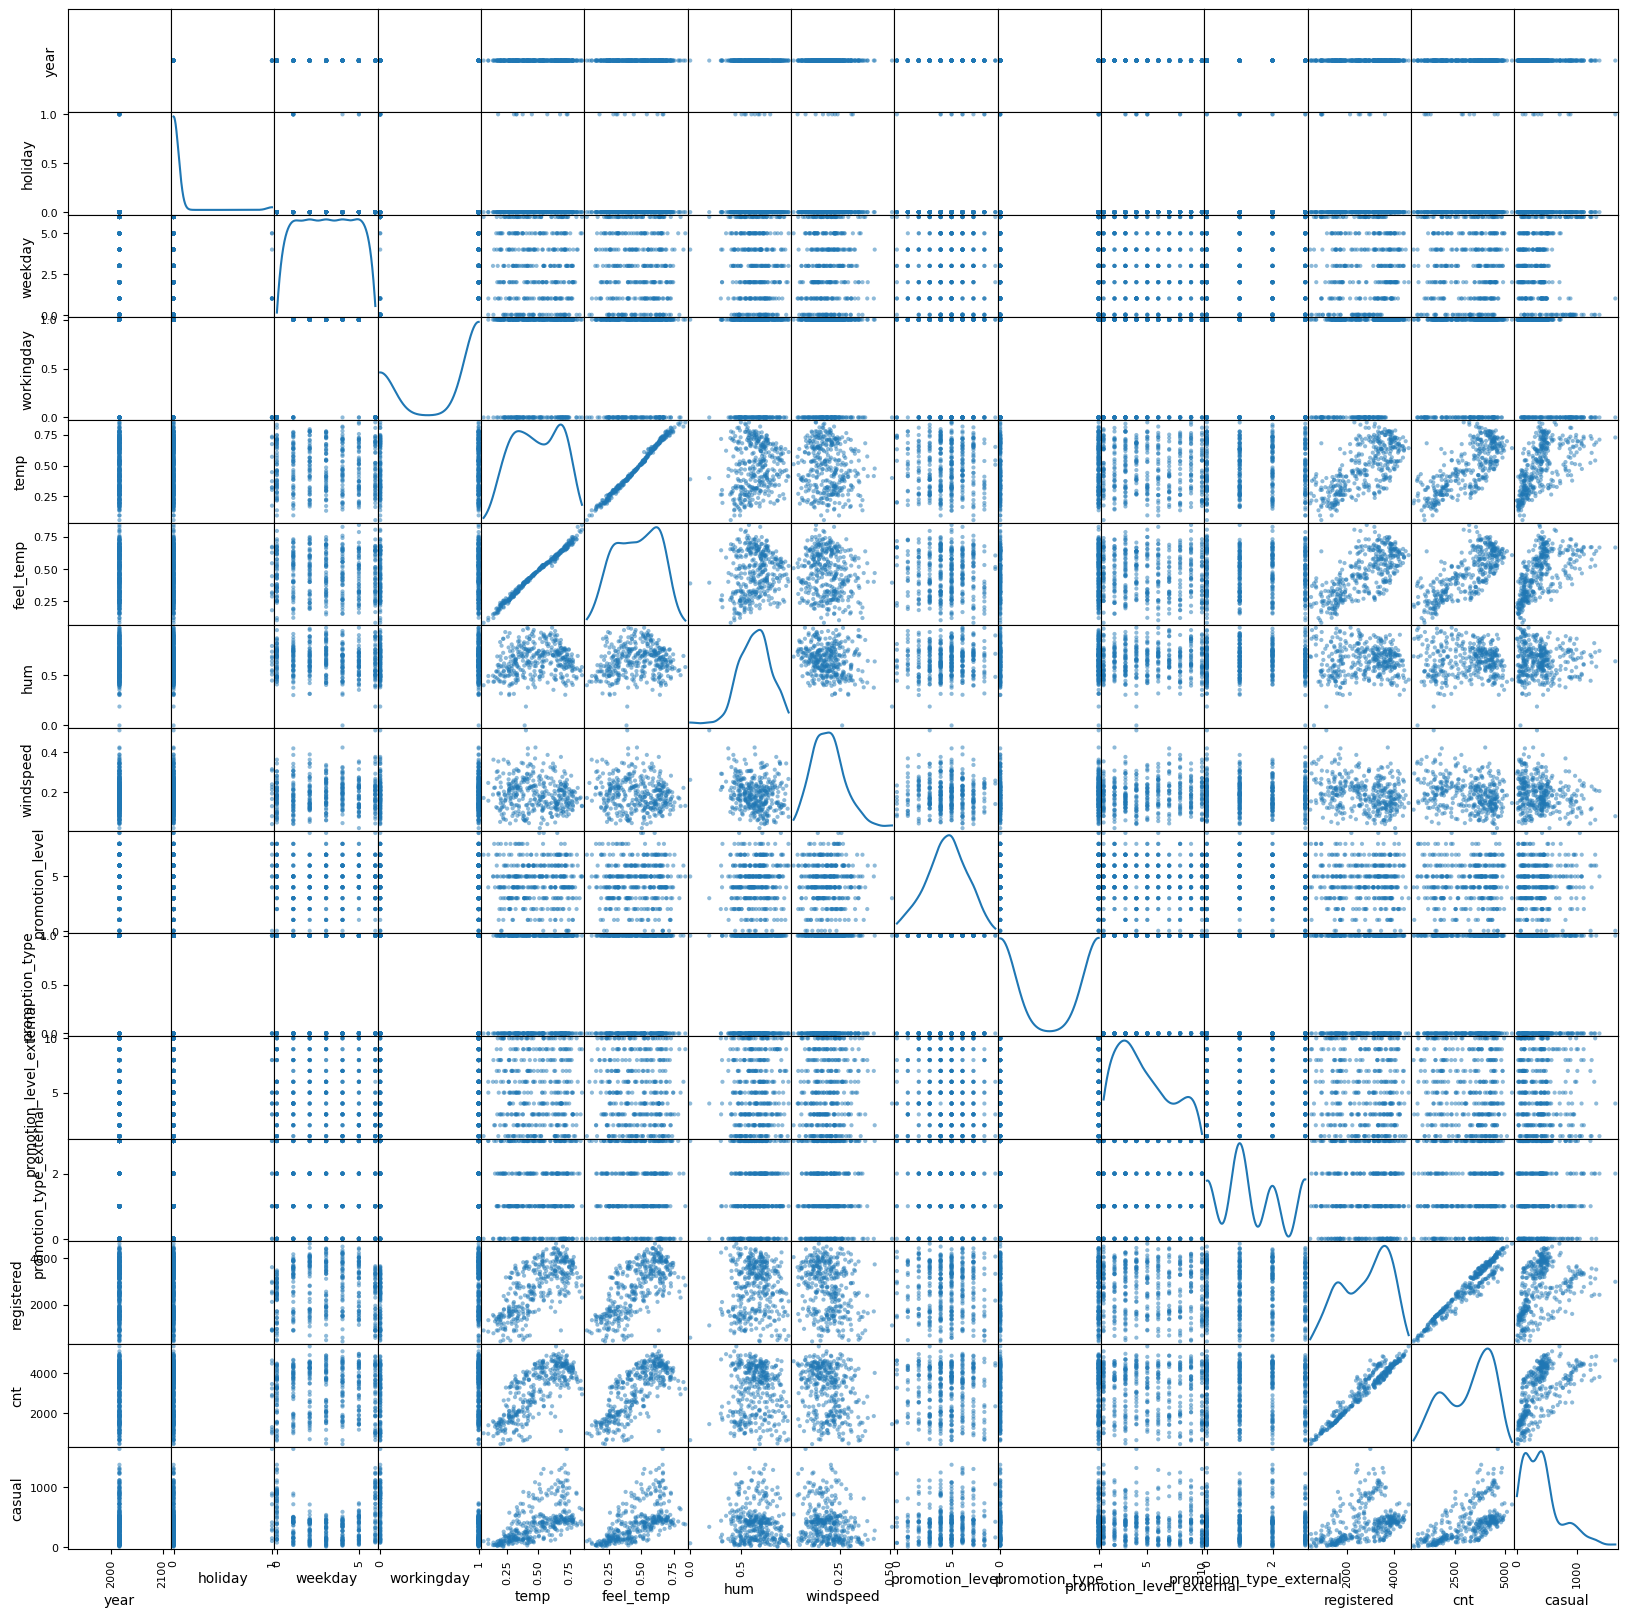

In [9]:
df = bike_df.drop(columns =["casual", 'id'], axis=1).join(bike_df.casual)
pd.plotting.scatter_matrix(df, diagonal='kde', figsize=(20,20))
#plt.show()

In [47]:
# OHE - season feature
dummyseason = pd.get_dummies(bike_df.season)
dummyseason.head()
bike_df = bike_df.drop('season', axis=1).join(dummyseason)
bike_df.head()

,id,year,holiday,weekday,workingday,weather,temp,feel_temp,hum,windspeed,...,promotion_type,promotion_level_external,promotion_type_external,casual,registered,cnt,autumn,spring,summer,winter
0,12765,2016,0,6,0,cloud,0.344167,0.363625,0.805833,0.160446,...,1,2,2,226,654,880,0,0,0,1
1,12766,2016,0,0,0,cloud,0.363478,0.353739,0.696087,0.248539,...,1,8,1,125,670,795,0,0,0,1
2,12767,2016,0,1,1,fair,0.196364,0.189405,0.437273,0.248309,...,1,10,2,75,1229,1304,0,0,0,1
3,12768,2016,0,2,1,fair,0.200000,0.212122,0.590435,0.160296,...,1,8,3,67,1454,1521,0,0,0,1
4,12769,2016,0,3,1,fair,0.226957,0.229270,0.436957,0.186900,...,0,5,1,58,1518,1576,0,0,0,1


In [48]:
# OHE - weather feature
dummyseason = pd.get_dummies(bike_df.weather)
dummyseason.head()
bike_df = bike_df.drop('weather', axis=1).join(dummyseason)
bike_df.head()

,id,year,holiday,weekday,workingday,temp,feel_temp,hum,windspeed,promotion_level,...,casual,registered,cnt,autumn,spring,summer,winter,cloud,fair,rain
0,12765,2016,0,6,0,0.344167,0.363625,0.805833,0.160446,7,...,226,654,880,0,0,0,1,1,0,0
1,12766,2016,0,0,0,0.363478,0.353739,0.696087,0.248539,8,...,125,670,795,0,0,0,1,1,0,0
2,12767,2016,0,1,1,0.196364,0.189405,0.437273,0.248309,3,...,75,1229,1304,0,0,0,1,0,1,0
3,12768,2016,0,2,1,0.200000,0.212122,0.590435,0.160296,0,...,67,1454,1521,0,0,0,1,0,1,0
4,12769,2016,0,3,1,0.226957,0.229270,0.436957,0.186900,2,...,58,1518,1576,0,0,0,1,0,1,0


In [49]:
# Remove unecessary features
bike_dfcopy = bike_df.drop(columns=['id', 'holiday', 'weekday', 'cnt',
                                    'autumn', 'fair'], axis=1)
bike_dfcopy.head()

,year,workingday,temp,feel_temp,hum,windspeed,promotion_level,promotion_type,promotion_level_external,promotion_type_external,casual,registered,spring,summer,winter,cloud,rain
0,2016,0,0.344167,0.363625,0.805833,0.160446,7,1,2,2,226,654,0,0,1,1,0
1,2016,0,0.363478,0.353739,0.696087,0.248539,8,1,8,1,125,670,0,0,1,1,0
2,2016,1,0.196364,0.189405,0.437273,0.248309,3,1,10,2,75,1229,0,0,1,0,0
3,2016,1,0.200000,0.212122,0.590435,0.160296,0,1,8,3,67,1454,0,0,1,0,0
4,2016,1,0.226957,0.229270,0.436957,0.186900,2,0,5,1,58,1518,0,0,1,0,0


In [19]:
bike_dfcopy.head()

,workingday,feel_temp,hum,windspeed,promotion_level,promotion_type,promotion_level_external,promotion_type_external,casual,registered,spring,summer,winter,cloud,rain
0,0,0.363625,0.805833,0.160446,7,1,2,2,226,654,0,0,1,1,0
1,0,0.353739,0.696087,0.248539,8,1,8,1,125,670,0,0,1,1,0
2,1,0.189405,0.437273,0.248309,3,1,10,2,75,1229,0,0,1,0,0
3,1,0.212122,0.590435,0.160296,0,1,8,3,67,1454,0,0,1,0,0
4,1,0.229270,0.436957,0.186900,2,0,5,1,58,1518,0,0,1,0,0


In [50]:
# Define the X (input) and y (target) features
X = bike_dfcopy.drop( "casual", axis=1)
y = bike_dfcopy["casual"]

# Rescale the input features
scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

#splitting your dataset into training and test sets, based on random sampling and returns 
# an evaluation of the model based on R-squared score
# Train test split
test_size = 0.33
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# Create model
model = LinearRegression()

# Fit model
model.fit(X_train, y_train)

# Evaluate model
predictions = model.predict(X_test)
r2_score(y_test, predictions)

0.741715973846555

In [51]:
from sklearn.model_selection import cross_val_score
# Create 5 folds
seed = 7
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

# Create a model 
model = LinearRegression()

# Train and evaluate multiple models using kfolds
results = cross_val_score(model, X, y, cv=kfold, scoring='r2')
print(results)
print("Mean:", results.mean())
print("Std:", results.std())

#Note that we don't need to explicitly perform the train/test splits. 
#The KFold object passed to the cross_val_score() function does this for us.

[0.74386542 0.77854915 0.71291466 0.68537137 0.69298526 0.82757716
 0.78496591 0.8043551  0.79629353 0.79687466]
Mean: 0.7623752220230244
Std: 0.047602227989198616


In [52]:
# Perform feature selection using a variance threshold of 0.01 (look for features explaining very little of the total variance)
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(0.01))
sel.fit(X_train)

print("Feature selection", sel.get_support())
print("Selected features:", list((bike_dfcopy.drop(columns=[ "casual"], axis=1)).columns[sel.get_support()]))
print("Removed features:", list((bike_dfcopy.drop(columns=[ "casual"], axis=1)).columns[~sel.get_support()]))

Feature selection [False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
Selected features: ['workingday', 'temp', 'feel_temp', 'hum', 'windspeed', 'promotion_level', 'promotion_type', 'promotion_level_external', 'promotion_type_external', 'registered', 'spring', 'summer', 'winter', 'cloud', 'rain']
Removed features: ['year']


In [ ]:
# spotting colinearity among features
bikefeaturescorr = (bike_dfcopy.drop(columns=["id", "registered", "winter", "fair", "casual"], axis=1)).corr()

In [53]:
def correlationMatrix(df):
    '''Show a correlation matrix for all features.'''
    columns = df.select_dtypes(include=['float64','int64']).columns
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(df.corr(), vmin=-1, vmax=1, interpolation='none',cmap='RdYlBu')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(columns)))
    ax.set_yticks(np.arange(len(columns)))
    ax.set_xticklabels(columns, rotation = 90)
    ax.set_yticklabels(columns)
    plt.show() 

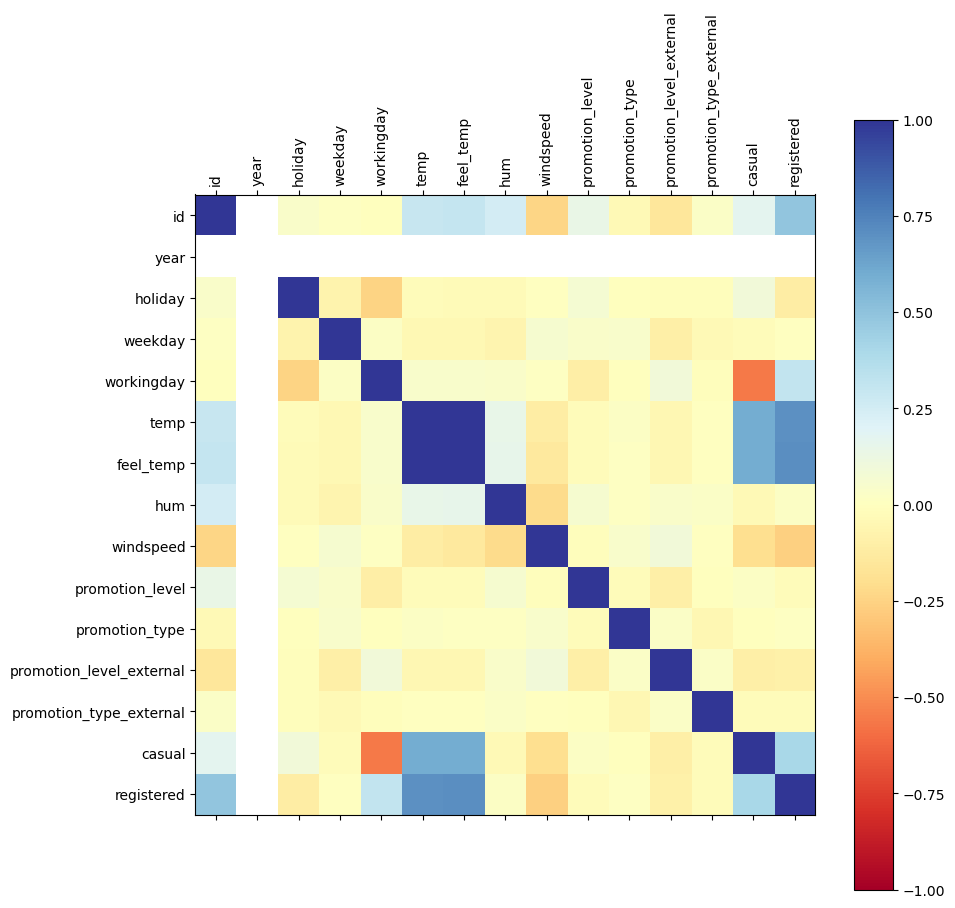

In [54]:
correlationMatrix(bike_df.loc[:, :'registered'])

In [55]:
# Function to list features that are correlated
# Adds the first of the correlated pair only (not both)
def correlatedFeatures(dataset, threshold):
    correlated_columns = set()
    correlations = dataset.corr()
    for i in range(len(correlations)):
        for j in range(i):
            if abs(correlations.iloc[i,j]) > threshold:
                correlated_columns.add(correlations.columns[i])
    return correlated_columns
correlatedFeatures(bike_dfcopy.drop('casual', axis=1), 0.85)

{'feel_temp'}

In [56]:
# Perform feature selection using a univariate statistical test
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif # use this for classification tasks
from sklearn.feature_selection import f_regression # use this for regression tasks

kbest = SelectKBest(score_func=f_regression, k=3)
kbest.fit(X_train, y_train)

print("Feature selection", kbest.get_support())
print("Feature scores", kbest.scores_)
print("Selected features:", list((bike_dfcopy.drop(columns=[ "casual"], axis=1)).columns[kbest.get_support()]))
print("Removed features:", list((bike_dfcopy.drop(columns=[ "casual"], axis=1)).columns[~kbest.get_support()]))

Feature selection [False  True  True  True False False False False False False False False
 False False False False]
Feature scores [0.00000000e+00 1.07510331e+02 1.44104421e+02 1.44044235e+02
 4.60414046e-01 5.99425266e+00 4.13678168e-02 1.05850144e+00
 8.40335358e-01 3.19693585e-01 5.11878295e+01 3.78315594e+00
 4.93297076e+01 1.00858418e+02 9.54018630e+00 1.32516425e+01]
Selected features: ['workingday', 'temp', 'feel_temp']
Removed features: ['year', 'hum', 'windspeed', 'promotion_level', 'promotion_type', 'promotion_level_external', 'promotion_type_external', 'registered', 'spring', 'summer', 'winter', 'cloud', 'rain']


In [57]:
# Feature selection using Recursive Feature Elimimation
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# Create a model
model_rfe = LinearRegression()

# Select the best 3 features according to RFE
rfe = RFE(model_rfe, 3)
rfe.fit(X_train, y_train)

print("Feature selection", rfe.support_)
print("Feature ranking", rfe.ranking_)
#print("Selected features:", list(((bike_dfcopy.drop(columns=["id", "registered", "winter", "fair", "casual"], axis=1)).feature_names[rfe.support_]))

TypeError: RFE.__init__() takes 2 positional arguments but 3 were given

In [61]:
# Lasso
from sklearn.linear_model import LassoCV
# Split into X and y
X = bike_dfcopy.drop("casual", axis=1).values
y = bike_dfcopy["casual"].values
#X = X.loc[:, 'MS SubClass':'MS Zoning_RM']
X_dataset = X

# Rescale the input features
scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

# Train test split
test_size = 0.33
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
# Create model
model_l = LassoCV(alphas=2)

# Fit model
model_l.fit(X_train, y_train)
predictions = model_l.predict(X_train)
print("Train:", r2_score(y_train, predictions))

# Evaluate
predictions = model_l.predict(X_test)
print("Test:", r2_score(y_test, predictions))

AxisError: axis -1 is out of bounds for array of dimension 0

In [42]:
y_train.shape

(244,)

## Methodes ensemblistes

In [1]:
%matplotlib inline

In [2]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [3]:
X, y = make_moons(n_samples=100, noise=0.25)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [5]:
X_test.shape

(25, 2)

In [6]:
from sklearn.ensemble import BaggingClassifier

In [8]:
model = BaggingClassifier(n_estimators=5)

In [9]:
model.fit(X_train, y_train)

BaggingClassifier(n_estimators=5)

In [10]:
import pandas as pd

## Random Forests

In [12]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [13]:
train.shape

(7352, 563)

In [17]:
train.isna().sum()

tBodyAcc-mean()-X       0
tBodyAcc-mean()-Y       0
tBodyAcc-mean()-Z       0
tBodyAcc-std()-X        0
tBodyAcc-std()-Y        0
                       ..
angle(X,gravityMean)    0
angle(Y,gravityMean)    0
angle(Z,gravityMean)    0
subject                 0
Activity                0
Length: 563, dtype: int64

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
X_train = train[train.columns[:-2]]
y_train = train['Activity']

X_test = test[test.columns[:-2]]
y_test = test['Activity']

In [29]:
# on cree un modele avec 1000 arbres de decision
rfc = RandomForestClassifier(n_estimators=500) 

In [30]:
start_time = timeit.default_timer()
model = rfc.fit(X_train, y_train)

In [31]:
from sklearn.metrics import accuracy_score

pred = rfc.predict(X_test)
print("accuracy {:.2f}".format(accuracy_score(y_test, pred)))
elapsed = timeit.default_timer() - start_time
accuracy = accuracy_score(y_test, pred)

print("accuracy {:.2f} time {:.2f}s".format(accuracy, elapsed))

accuracy 0.93
accuracy 0.93 time 195.37s


In [32]:
from sklearn.feature_selection import SelectFromModel
select = SelectFromModel(rfc, prefit=True, threshold=0.003)
X_train2 = select.transform(X_train)
print(X_train2.shape)

(7352, 81)


/Users/souha_kassab/opt/miniconda3/envs/OC_Project2/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [33]:
import timeit

rfc2 = RandomForestClassifier(n_estimators=500, oob_score=True)

start_time = timeit.default_timer()

rfc2 = rfc2.fit(X_train2, y_train)

X_test2 = select.transform(X_test)

pred = rfc2.predict(X_test2)
elapsed = timeit.default_timer() - start_time
accuracy = accuracy_score(y_test, pred)

print("accuracy {:.2f} time {:.2f}s".format(accuracy, elapsed))

/Users/souha_kassab/opt/miniconda3/envs/OC_Project2/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


accuracy 0.89 time 18.65s
